# Accelerating training of a DNN using SVD - Cats Example

Example on the Cat vs non-cat dataset (https://www.floydhub.com/deeplearningai/datasets/cat-vs-noncat).

SVD-DNN shows improvements in training speed

Note that the model in this notebook was not trained to convergence (you can get better results by training it more, SVD-DNN shows improvements in accuracy too)

In [2]:
using HDF5
using Images

using LinearAlgebra

using Flux
using Flux: @epochs
using Flux.Data: DataLoader
using Flux.Optimise
using Zygote: Params

using BenchmarkTools: @btime
using TimerOutputs

using Plots

In [42]:
include("../SVDNN.jl")
include("../SVDNN_utils.jl")

train_epochs_svd! (generic function with 3 methods)

In [47]:
reset_timer!(to)

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      285ms / 0.00%           28.3MiB / 0.00%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 ──────────────────────────────────────────────────────────────────

## Load data

In [4]:
TRAIN_DATA_PATH="datasets/train_catvnoncat.h5"
TEST_DATA_PATH="datasets/test_catvnoncat.h5"

"datasets/test_catvnoncat.h5"

In [5]:
train_data_x_orig = h5read(TRAIN_DATA_PATH, "train_set_x")
train_data_y_orig = h5read(TRAIN_DATA_PATH, "train_set_y")
nothing

In [6]:
test_data_x_orig = h5read(TEST_DATA_PATH, "test_set_x")
test_data_y_orig = h5read(TEST_DATA_PATH, "test_set_y")
nothing

In [7]:
classes = h5read(TEST_DATA_PATH, "list_classes")

2-element Array{String,1}:
 "non-cat"
 "cat"    

In [8]:
train_data_y_orig = reshape(train_data_y_orig, (1, size(train_data_y_orig)[1]))
test_data_y_orig = reshape(test_data_y_orig, (1, size(test_data_y_orig)[1]))

1×50 Array{Int64,2}:
 1  1  1  1  1  0  1  1  1  1  1  1  1  …  0  0  1  1  1  0  0  0  1  1  1  0

In [9]:
function reshape_image_array(image_array::Array{UInt8,4})
    return reshape(image_array, :, size(image_array)[4])
end
function reshape_image_array_reverse(image_array::Array{UInt8,2})
    return reshape(image_array, 64, 64, 3, :)
end
function reshape_image_array_reverse(image_array::Array{Float32,2})
    return reshape(image_array, 64, 64, 3, :)
end

reshape_image_array_reverse (generic function with 2 methods)

In [10]:
test_data_x = reshape_image_array(copy(permuteddimsview(test_data_x_orig, [3, 2, 1, 4])))
test_data_x = Array{Float32, 2}(test_data_x) ./ 255

train_data_x = reshape_image_array(copy(permuteddimsview(train_data_x_orig, [3, 2, 1, 4])))
train_data_x = Array{Float32, 2}(train_data_x) ./ 255

nothing

## Model

In [11]:
num_features = 12288  # size of each input vector
num_hidden_layer_neurons = 100  # Number of neurons in hidden layer
learning_rate = 0.001

0.001

In [12]:
# for SVD training
max_l = (num_features * num_hidden_layer_neurons) / (num_features + num_hidden_layer_neurons)
print("Keep l lesser than $max_l")
l_values = [50, 1]

Keep l lesser than 99.19276719405876

2-element Array{Int64,1}:
 50
  1

In [13]:
data = DataLoader(train_data_x, train_data_y_orig)
test_data = DataLoader(test_data_x, test_data_y_orig)

DataLoader((Float32[0.61960787 0.4509804 … 0.07058824 0.52156866; 0.61960787 0.48235294 … 0.08235294 0.30980393; … ; 0.41568628 0.7490196 … 0.5137255 0.07058824; 0.43137255 0.7294118 … 0.42352942 0.019607844], [1 1 … 1 0]), 1, 50, true, 50, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  41, 42, 43, 44, 45, 46, 47, 48, 49, 50], false)

In [55]:
# build model
model = Chain(
              Dense(num_features, num_hidden_layer_neurons, relu),
              Dense(num_hidden_layer_neurons, 1, σ)
             )

# store parameters of model
ps = params(model)
println("Model has $(sum(length, ps)) parameters")

# optimizer, gradient descent
opt = Descent(learning_rate)

# loss function
loss(x, y, model) = Flux.binarycrossentropy(model(x)[1], y[1]) #+ α_norm * sum(norm, params(model))

# arrays for plotting graphs
costs = []
accuracies = []
test_accuracies = []

Model has 1229001 parameters


0-element Array{Any,1}

In [15]:
function cost_function(data, loss, model)
    losses = []
    for (x, y) in data
        push!(losses, loss(x, y, model))
    end
    avg_loss = sum(losses)/length(losses)
    return avg_loss
end

function accuracy(data, model)
    corrects = []
    for (x, y) in data
        pred = model(x)[1]
        pred = pred >= 0.5 ? 1 : 0
        push!(corrects, pred == y[1])
    end
    return sum(corrects)/length(corrects)
end

accuracy (generic function with 1 method)

# SVD Train

In [56]:
@timeit to "Full training SVD" train_epochs_svd!(model, l_values, loss, data, test_data,
                                                 opt, opt, 20)

Cost at epoch 1 is 0.6961822. Accuracy 0.6555023923444976. Test accuracy 0.34
Cost at epoch 2 is 0.6727652. Accuracy 0.6555023923444976. Test accuracy 0.34
Finished pre-training
Built SVD model
SVD Model: Accuracy 0.6555023923444976. Test accuracy 0.34
Begin tuning SVD model
Cost at epoch 1 is 0.6493531. Accuracy 0.6555023923444976. Test accuracy 0.34
Cost at epoch 2 is 0.6519461. Accuracy 0.6602870813397129. Test accuracy 0.34
Cost at epoch 3 is 0.6340031. Accuracy 0.6602870813397129. Test accuracy 0.34
Cost at epoch 4 is 0.63229537. Accuracy 0.6650717703349283. Test accuracy 0.34
Cost at epoch 5 is 0.6046926. Accuracy 0.6698564593301436. Test accuracy 0.34
Cost at epoch 6 is 0.5825674. Accuracy 0.6842105263157895. Test accuracy 0.34
Cost at epoch 7 is 0.56422955. Accuracy 0.69377990430622. Test accuracy 0.34
Cost at epoch 8 is 0.5469585. Accuracy 0.7033492822966507. Test accuracy 0.36
Cost at epoch 9 is 0.53021085. Accuracy 0.722488038277512. Test accuracy 0.38
Cost at epoch 10 is 0.

In [57]:
print_timer(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:             237s / 57.7%           34.4GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 Full training              2    92.8s  67.9%   46.4s   22.8GiB  66.3%  11.4GiB
   Train one step          23    80.5s  58.9%   3.50s   22.3GiB  64.8%  0.97GiB
     Update params      4.76k    41.4s  30.3%  8.70ms     0.00B  0.00%    0.00B
     Calculate grad...  4.76k    38.4s  28.1%  8.06ms   22.1GiB  64.2%  4.74MiB
     Get params            23    540μs  0.00%  23.5μs   23.4KiB  0.00%  1.02KiB
   Calculate cost          22    6.60s  4.83%   300ms    225MiB  0.64%  10.2MiB
   Calculate accuracy      22    4.49s 

It can be seen in the previous cell's output that training one step of SVD-DNN takes significantly less time than that of the normal DNN.

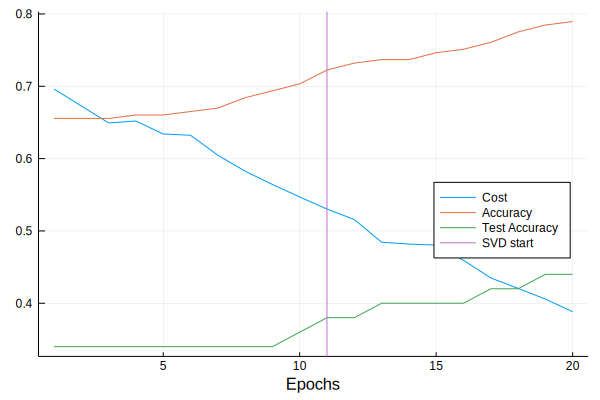

In [58]:
plot(costs, label = "Cost")
plot!(accuracies, label = "Accuracy")
plot!(test_accuracies, label = "Test Accuracy")
xlabel!("Epochs")
vline!([11], label = "SVD start", legend = :right)

# Normal Model

Initialize model (from [Model](#Model)) before running

In [52]:
@timeit to "Full training" train_epochs!(loss, data, test_data, opt, model, 20)

Cost at epoch 1 is 0.693501. Accuracy 0.6507177033492823. Test accuracy 0.34
Cost at epoch 2 is 0.668917. Accuracy 0.6602870813397129. Test accuracy 0.34
Cost at epoch 3 is 0.6536845. Accuracy 0.6602870813397129. Test accuracy 0.34
Cost at epoch 4 is 0.6422135. Accuracy 0.6698564593301436. Test accuracy 0.34
Cost at epoch 5 is 0.60601115. Accuracy 0.6794258373205742. Test accuracy 0.34
Cost at epoch 6 is 0.5913277. Accuracy 0.6794258373205742. Test accuracy 0.34
Cost at epoch 7 is 0.56927574. Accuracy 0.7033492822966507. Test accuracy 0.38
Cost at epoch 8 is 0.5486844. Accuracy 0.6985645933014354. Test accuracy 0.38
Cost at epoch 9 is 0.53253067. Accuracy 0.7081339712918661. Test accuracy 0.36
Cost at epoch 10 is 0.508357. Accuracy 0.722488038277512. Test accuracy 0.38
Cost at epoch 11 is 0.50316566. Accuracy 0.7272727272727273. Test accuracy 0.38
Cost at epoch 12 is 0.4885759. Accuracy 0.7416267942583732. Test accuracy 0.38
Cost at epoch 13 is 0.47492504. Accuracy 0.7464114832535885. 

In [53]:
print_timer(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:             108s / 86.2%           22.8GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 Full training              2    92.8s   100%   46.4s   22.8GiB  100%   11.4GiB
   Train one step          23    80.5s  86.8%   3.50s   22.3GiB  97.8%  0.97GiB
     Update params      4.76k    41.4s  44.7%  8.70ms     0.00B  0.00%    0.00B
     Calculate grad...  4.76k    38.4s  41.4%  8.06ms   22.1GiB  96.9%  4.74MiB
     Get params            23    540μs  0.00%  23.5μs   23.4KiB  0.00%  1.02KiB
   Calculate cost          22    6.60s  7.11%   300ms    225MiB  0.96%  10.2MiB
   Calculate accuracy      22    4.49s 

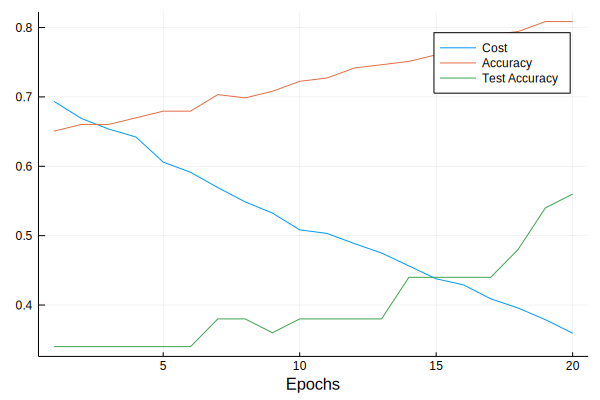

In [54]:
plot(costs, label = "Cost")
plot!(accuracies, label = "Accuracy")
plot!(test_accuracies, label = "Test Accuracy")
xlabel!("Epochs")

## Test on image

Ground truth 1
Prediction 1


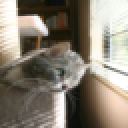

In [73]:
image_to_select = rand(1:size(train_data_x)[2])
a = reshape_image_array_reverse(train_data_x[:, [image_to_select]])
a2 = a[:,:,:,1]
a3 = permuteddimsview(a2, [3, 1, 2])
a3 = Array{Float32}(a3)
println("Ground truth ", train_data_y_orig[1, image_to_select])
println("Prediction ", model(train_data_x[:, image_to_select])[1] >= 0.5 ? 1 : 0)
# println("Filename ", df[image_to_select, 1])
colorview(RGB, a3)